In [2]:
from scipy import integrate
from scipy import sparse
import scipy as scp

import matplotlib.pyplot as plt
import imageio
import glob
import os
from matplotlib import rc
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

import numpy as np
dx    = 0.05  # spatial separation
dt = dx**2
print(dt/dx**2)
x     = np.arange(-50, 50, dx)       # spatial grid points

k0    = 15          # wave number
m     = 1                          # mass
sigma = 0.1                        # width of initial gaussian wave-packet
x0    = 3.0                        # center of initial gaussian wave-packet

a = 5
i = complex(0,1)

psi0 = ((2*a)/np.pi)**(1/4) * np.exp(-a*x**2) * np.exp(i*k0*x)

V_height = 400
V = np.zeros(np.shape(x))
for i, _x in enumerate(x):
    if round(_x, 2) == (-2.5) or round(_x, 2) == (2.5)  :
        V[i] = V_height
#print(x)
#print(V)
hbar = 1
# hbar = 1.0545718176461565e-34

# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], 
                  [-1, 0, 1], shape=(x.size, x.size)) / dx**2

def dx2(psi, V, hbar=1,m=1):
    i=complex(0,1)
    return -(i/hbar) * (-0.5* (hbar**2/m) * np.dot(D2.toarray(), psi) + V * psi)

def rk4(psi,V, dt, **kwargs):
    k1 = dx2(psi,V,**kwargs)
    k2 = dx2(psi+dt/2*k1,V,**kwargs)
    k3 = dx2(psi+dt/2*k2, V,**kwargs)
    k4 = dx2(psi+dt*k3,V, **kwargs)
    return psi + dt/6*(k1+2*k2+2*k3+k4)
def Normalise_wf(wf, x):
    wf2= scp.integrate.simps(abs(wf) ** 2, x)
    return wf2

t0 = 0.0    # initial time
tf = 0.5  # final time
t_eval = np.arange(t0, tf, dt)  # recorded time shots
# Solve the Initial Value Problem
# sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")


sol = np.zeros((len(x),len(t_eval)), dtype=complex)

sol[:,0]=psi0

for n in range(1,len(t_eval)):
    sol[:,n]=rk4(sol[:,n-1],V,dt)

def an_stat(x,t,a,hbar=1,m=1):
    b = 1 + ((2 * hbar * a * t)/m)**2
    return np.sqrt(2*a/np.pi) * 1/np.sqrt(b) * np.exp(-2*a*x**2/b)

def an_moving(x,t,a,k0,hbar=1,m=1):
    b = a**2 * (m+2)
    return 4*np.sqrt(2*np.pi*a**3) * (np.exp((2*m*k0**2-4*m*a*x**2)/(b))+np.exp((2*k0**2*hbar*a*t)/b))
def create_frame(n,x, psi,dt, k0=3):
    # rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    # rc('text', usetex=True)
    
    fig = plt.figure(figsize=(8, 5))
    ax = plt.gca()
    plt.plot(x, psi,label='numerical')
    plt.plot(x, V/100,label='potential')
    plt.ylim(0,3)
    plt.xlim(-6.5,6.5)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(r'$|\Psi(x,t)|^2$', fontsize=16)
    plt.xlabel(r'$x$',fontsize=16)
    #plt.plot(x,an_moving(x,n*dt,a),label= 'analytical', alpha=0.6)
    # plt.plot(x,an_moving(x,n*dt,a,k0),label= 'analytical', alpha=0.6)
    
    plt.text(x=0.05, y=0.9, transform=ax.transAxes, s = f'$t$ = {np.round(n*dt,3)}', fontsize=16)
    
    P = np.round(np.sum((psi))*dx, 7)
    plt.text(x=0.4, y=0.9, transform=ax.transAxes, s = f'$P$ = {P}', fontsize=16)
    plt.legend(fontsize=16)
    plt.savefig(f'./Gaussian/img_{int(n/10)}.png', 
                transparent = False,  
                facecolor = 'white',
                bbox_inches='tight'
               )
    plt.close()

1.0


In [3]:
frames = []
for i in range(0,len(t_eval)):
    
    if i%10 == 0 :
        # Plot Wavefunctions
        create_frame(i,x,(np.abs(sol[:,i])**2),dt)
        image = imageio.v2.imread(f'./Gaussian/img_{int(i/10)}.png')
        frames.append(image)

    # print(np.sum(np.abs(sol.y[:,i])**2)*dx)        # Print Total Probability (Should = 1)
imageio.mimsave(f'./Gaussian/Gaussian.gif', frames, fps=15, loop=0)         
  
# # deletes all frames in img dir
# dir_path = "./img/"
# file_pattern = "*.png"
# file_paths = glob.glob(os.path.join(dir_path, file_pattern))
# for file_path in file_paths:
#     os.remove(file_path)
print('done')

done


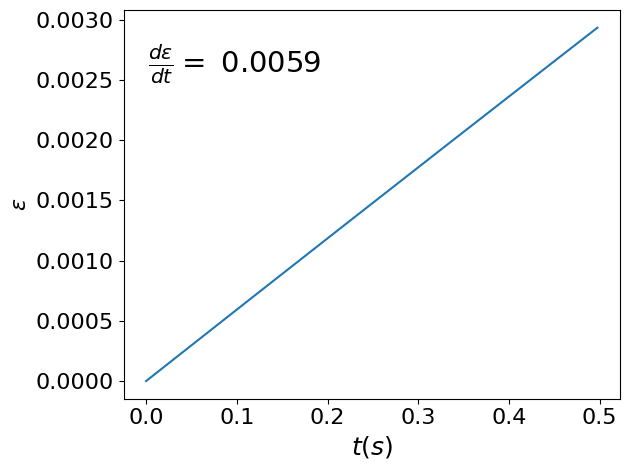

In [4]:
from matplotlib import rc
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)

def Nu_Prob_Graph(sol, t_eval):
    P = []
    for i in range(0,len(t_eval)):
        P.append(np.abs( 1- np.sum((np.abs(sol[:,i])**2))*dx ))
    
    rate = np.round(P[-1]/t_eval[-1],5)
    plt.plot(t_eval, P)
    ax = plt.gca()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(r'$\epsilon$', fontsize=16)
    plt.xlabel(r'$t(s)$',fontsize=18)
    plt.text(x=0.05, y=0.84, transform=ax.transAxes, s = r'$\frac{d\epsilon}{dt} = $' f' {rate}', fontsize=21)
    # plt.grid()
    plt.tight_layout()
    plt.savefig('finitewell_prob_graph.pdf',bbox_inches='tight')
    plt.show()
    
Nu_Prob_Graph(sol, t_eval)